# Arithmetic Experiments

## Imports

In [1]:
from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)

from implicitdl import ImplicitModel, ImplicitFunctionInf

import torch
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda')
print('using ' + str(device))

import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(123)
%matplotlib inline

using cuda


## Data Generation

In [2]:
DIM = 50
SAMPLES = 10000

randrange = lambda dim: sorted(np.random.choice(range(dim+1), size=2, replace=False))

funcs = {
    'addition': lambda a, b: a+b,
    'subtraction': lambda a, b: a-b,
    'mul': lambda a, b: a*b,
    'div': lambda a, b: a/b
}

n, m = randrange(DIM)
p, q = randrange(DIM)

def make_data(lower, upper, func):
    X = torch.tensor(np.random.uniform(lower, upper, size=(SAMPLES, DIM)), device=device, dtype=torch.float)
    a = X[:, n:m].sum(axis=-1).unsqueeze(-1)
    b = X[:, p:q].sum(axis=-1).unsqueeze(-1)
    y = func(a, b)
    return X, y

## Training Code

In [3]:
def train(model, X, y, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []
    
    model.train()
    with trange(epochs) as it:
        for i in it:
            pred = model(X)
            loss = F.mse_loss(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            losses.append(loss.item())
            it.set_postfix(lr=scheduler.get_last_lr()[0])
            
    return losses

## Model Generation
To override the default nonlinearity (ReLU), override the implicit function you wish to use, and replace the phi and dphi (gradient of nonlinearity) methods.

In [4]:
class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6

class ImplicitFunctionInfSiLU(CustomInf):
    """
    An implicit function that uses the SiLU nonlinearity.
    """
    
    @staticmethod
    def phi(X):
        return X * torch.sigmoid(X)

    @staticmethod
    def dphi(X):
        grad = X.clone().detach()
        sigmoid = torch.sigmoid(grad)
        return sigmoid * (1 + grad * (1 - sigmoid))

In [5]:
input_size = DIM
hidden_size = 20
output_size = 1

make_imp_relu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=CustomInf)
make_imp_silu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionInfSiLU)

In [6]:
def make_mlp(act):
    return nn.Sequential(
        nn.Linear(DIM, hidden_size, bias=False),
        act(),
        nn.Linear(hidden_size, hidden_size, bias=False),
        act(),
        nn.Linear(hidden_size, hidden_size, bias=False),
        act(),
        nn.Linear(hidden_size, 1, bias=False),
    )

## Full Pipeline
Takes 1-2 minutes to run on one NVIDIA Tesla P100-PCIE-16GB.

In [7]:
EPOCHS = 1000
LR = 0.02

In [8]:
factors = np.logspace(1, 5, num=100)

def run_task(task):
    X, y = make_data(-1, 1, funcs[task])

    models = {
        'Implicit ReLU': make_imp_relu().to(device),
        'Implicit SiLU': make_imp_silu().to(device),
        'MLP ReLU': make_mlp(nn.ReLU).to(device),
        'MLP SiLU': make_mlp(nn.SiLU).to(device)
    }

    losses = {}

    print('Model Sizes:')
    for name, model in models.items():
        print(f'{name}: {sum(p.numel() for p in model.parameters())} parameters')
        
    print('\nTraining:')
    for name, model in models.items():
        print(name)
        losses[name] = train(model, X, y, EPOCHS, LR)
        
    print('\nExtrapolation')
    extraps = {name: [] for name in models}
    for factor in tqdm(factors):
        X_test, y_test = make_data(-factor/2, factor/2, funcs[task])
        for name, model in models.items():
            with torch.no_grad():
                extraps[name].append(F.mse_loss(model(X_test), y_test).item())
                
    return task, losses, extraps
  
def display_task(task, losses, extraps):
    fig, ax = plt.subplots()
    for name, train_loss in losses.items():
        ax.plot(np.log10(train_loss), label=name)

    ax.set_title(f'{task.title()} Training Comparison')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    for name, extraps in extraps.items():
        ax.plot(np.log10(factors), np.log10(extraps), label=name)

    ax.set_title(f'{task.title()} Extrapolation Comparison')
    ax.set_xlabel('Log10(Extrapolation Factor)')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    plt.show()

In [9]:
add_task = run_task('addition')

Model Sizes:
Implicit ReLU: 1470 parameters
Implicit SiLU: 1470 parameters
MLP ReLU: 1820 parameters
MLP SiLU: 1820 parameters

Training:
Implicit ReLU


  0%|          | 0/1000 [00:00<?, ?it/s]

Implicit SiLU


  0%|          | 0/1000 [00:00<?, ?it/s]

MLP ReLU


  0%|          | 0/1000 [00:00<?, ?it/s]

MLP SiLU


  0%|          | 0/1000 [00:00<?, ?it/s]


Extrapolation


  0%|          | 0/100 [00:00<?, ?it/s]

Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.4305e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard itera

Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard itera

In [10]:
sub_task = run_task('subtraction')

Model Sizes:
Implicit ReLU: 1470 parameters
Implicit SiLU: 1470 parameters
MLP ReLU: 1820 parameters
MLP SiLU: 1820 parameters

Training:
Implicit ReLU


  0%|          | 0/1000 [00:00<?, ?it/s]

Implicit SiLU


  0%|          | 0/1000 [00:00<?, ?it/s]

MLP ReLU


  0%|          | 0/1000 [00:00<?, ?it/s]

MLP SiLU


  0%|          | 0/1000 [00:00<?, ?it/s]


Extrapolation


  0%|          | 0/100 [00:00<?, ?it/s]

Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.4305e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=1.4305e-06, status=max itrs reached
Picard iterations did not converge: err=2.8610e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=2.8610e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=1.9073e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard itera

Picard iterations did not converge: err=3.6621e-04, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=3.6621e-04, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=3.6621e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=7.3242e-04, status=max itrs reached
Picard itera

## Plot Results

In [11]:
styles = ['-', '--', '-.', ':']

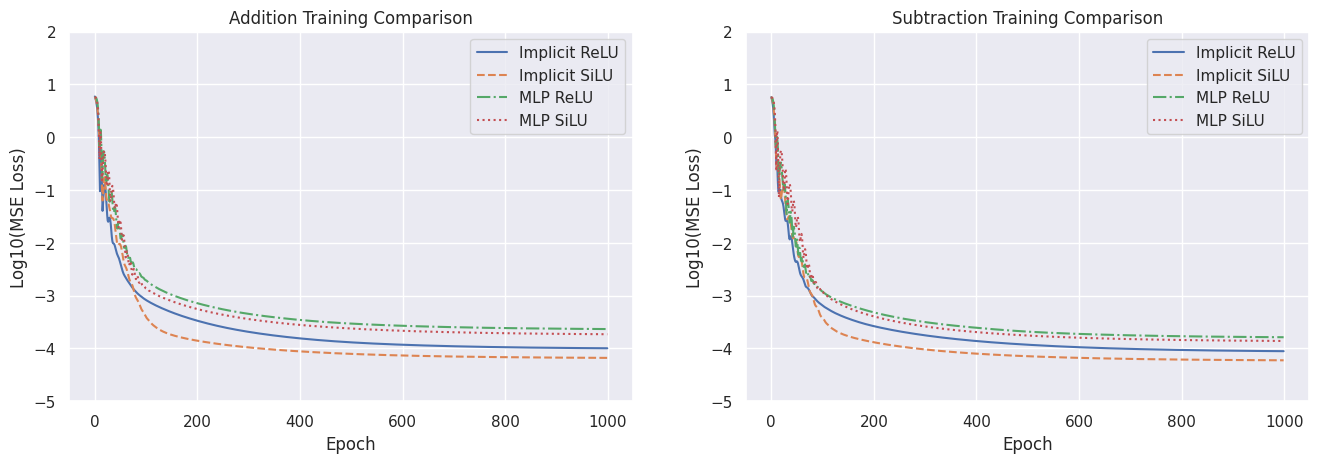

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(6.4*2.5, 4.8))

for ax, (name, losses, _) in zip(axes, [add_task, sub_task]):
    
    for style, (model_name, model_loss) in zip(styles, losses.items()):
        ax.plot(np.log10(model_loss), label=model_name, ls=style)
    
    ax.set_ylim(-5, 2)
    ax.set_title(f'{name.title()} Training Comparison')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    
plt.show()

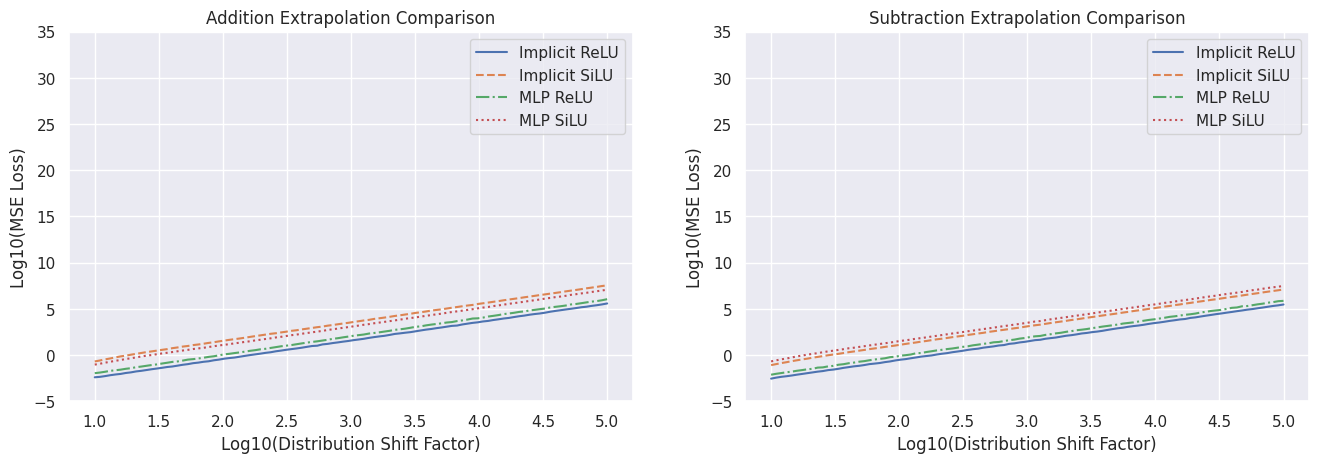

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(6.4*2.5, 4.8))

for ax, (name, _, extraps) in zip(axes, [add_task, sub_task]):
    
    for style, (model_name, model_extrap) in zip(styles, extraps.items()):
        ax.plot(np.log10(factors), np.log10(model_extrap), label=model_name, ls=style)
    
    ax.set_ylim(-5, 35)
    ax.set_title(f'{name.title()} Extrapolation Comparison')
    ax.set_xlabel('Log10(Distribution Shift Factor)')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    
plt.show()